# Research Question 1
**How does the number of distinct timezones and timezone difference of each repository correlate with the average time-to-merge a pull of a repository?** 

## 1. Process location and obtain average time to merge a pull request 😇
We start by reading the 2 collected data: one for collaborators, users and their location for each repository and the other one for the pull request of each repository. Both of these datasets were gathered and explained in data_collection.ipnyb. 

For each repositoy, we retrieved the location of all collaborators. In a json file, we placed all collaborators that have their location on their GitHub profile, removing all collaborators that have 'Null' values as their locations. The criteria of retrieving their location is the following: we will take the location of the user if they have it on their github, otherwise we take their location from their 'bio', and if they do not have these, we take their location from 'company' field. 

Moreover, we computed the average time-to-merge for all pull requests in the respective repository. This value can be computed in either hours or minutes. For our analysis we will use hours. 

Furthermore, we have reduced the number of repositories from 51 to 46 😅. This is due to the fact that there were 3 repositories with no pull requests, as we have not filtered them out in the initial part of the data collection. We had to remove these 3 repositories because our analysis surrounds the hypothesis of time-to-merge a pull request, therefore we had no pull requests to analyze in these repositories, thus we removed them. Lastly, we have found 2 repositories that have no collaborators that have location on, this is due to the fact that in the initial data collection process, the collaborators had their location on and passed our filtering criteria of having at least 0.1% of users with location on, however our program below does not parse the location if it is written in another language, and in our case, the location of a user was written in Korean, and our program below considers it as Null 💀. 

In [ ]:
import json
from datetime import datetime

def time_difference(d1, d2, unit='hours'):
    d1 = datetime.strptime(d1, '%Y-%m-%dT%H:%M:%SZ')
    d2 = datetime.strptime(d2, '%Y-%m-%dT%H:%M:%SZ')
    
    time_diff = d2 - d1
    
    if unit == 'hours':
        return time_diff.total_seconds() / 3600
    elif unit == 'minutes':
        return time_diff.total_seconds() / 60
    else:
        raise ValueError("Invalid unit. Please use 'hours' or 'minutes'.")

f1 = open("data/4_collaborators_and_users_with_timezone.json")
f2 = open("data/4_pull_requests.json")
data_tz = json.load(f1)
data_pr = json.load(f2)

repos = []

for item in data_pr:
    #print(f"repo name of pr is {item['full_name']}")
    pull_requests = []

    for entry in item['pull_requests']:
        if (entry['created_at'] and entry['merged_at']) is not None:
            pull_requests.append(time_difference(entry['created_at'], entry['merged_at'],'hours'))
    if len(pull_requests) == 0:
        average_pull_requests = 0
    elif len(pull_requests) > 0:
        average_pull_requests = sum(pull_requests) / len(pull_requests)
    
    repos.append({
        "repo_name": item['full_name'],
        "pull_requests": pull_requests,
        "pull_request_average": average_pull_requests
    })


final_repos = []
i = 0
for item in data_tz:
    locations = []
    for entry in item['users_location']:
        if 'bot' not in entry['login']:
            if entry['location'] is not None:
                locations.append(entry['location'])
            elif entry['bio'] is not None:
                locations.append(entry['bio'])
            elif entry['company'] is not None:
                locations.append(entry['company'])

    if len(locations) != 0:
        repo_index = next((i for i, r in enumerate(repos) if r["repo_name"] == item['name']), None)
        if repo_index is not None:
            if repos[repo_index]['pull_request_average'] != 0:
                final_repos.append({
                    "repo_name": item['name'],
                    "locations": locations,
                    "time_to_merge": repos[repo_index]['pull_requests'],
                    "time_to_merge_average": repos[repo_index]['pull_request_average']
                })
        i += 1

with open("data_rq1/RQ1_2_Locations_PR.json", "w") as outfile:
    json.dump(final_repos, outfile)
print("result written in data_rq1/RQ1_2_Locations_PR.json")

## 2. Retrieve UTC timezones for all collaborators that have their location on 🗺️

From the data we processed in the previous step, we further process it so that we place each location in it's respective UTC timezone. We count how many collaborators of a repository belong to a distinct timezone. We also keep the average time-to-merge for each repositoy.

Moreover, we also count how many distinct timezones there are in a single repository and we also retrieve the timezone difference within a repository. In our case, the timezone difference is the absolute sum of the lowest and highest UTC timezone. For example, if repository A has collaborators from the following UTC timezones: UTC-7, UTC-1, UTC+4 and UTC+10, then the timezone difference will be 17 hours (absolute sum of UTC-7 and UTC+10) 🤓.

In [15]:
import pytz
from datetime import datetime, timezone
from collections import defaultdict
import json

f = open("data_rq1/RQ1_2_Locations_PR.json")
location_data = json.load(f)

# Initialize the output dictionary
output_data = {}

for item in location_data:
    repo_name = item['repo_name']
    if repo_name not in output_data:
        output_data[repo_name] = {
            "average_pr_time": item['time_to_merge_average']
        }

    timezone_counts = defaultdict(int)
    timezone_offsets = []
    for location in item['locations']:
        try:
            tz_obj = pytz.timezone(location)
            utc_offset = tz_obj.utcoffset(datetime.now())
            if utc_offset.total_seconds() == 0:
                tz_offset_str = "UTC+0"
            else:
                tz_offset_str = f"UTC{'+' if utc_offset.total_seconds() > 0 else '-'}{abs(int(utc_offset.total_seconds() / 3600))}"
            timezone_counts[tz_offset_str] += 1
            
            # Extract the numeric offset from the string
            if tz_offset_str.startswith("UTC+"):
                timezone_offsets.append(int(tz_offset_str[4:]))
            elif tz_offset_str.startswith("UTC-"):
                timezone_offsets.append(-int(tz_offset_str[4:]))
            else:
                timezone_offsets.append(0)
        except pytz.exceptions.UnknownTimeZoneError:
            print(f"Unknown timezone: {location}")

    for timezone, count in timezone_counts.items():
        output_data[repo_name][timezone] = count
    output_data[repo_name]['nr_timezones'] = len(timezone_counts)

    # Calculate the timezone difference
    min_offset = min(timezone_offsets)
    max_offset = max(timezone_offsets)
    timezone_difference = abs(max_offset - min_offset)
    output_data[repo_name]['timezone_difference'] = timezone_difference

with open("data_rq1/RQ1_utc_count_avg_prs.json", "w") as outfile:
    json.dump(output_data, outfile)

print("Result written in data_rq1/RQ1_utc_count_avg_prs.json")

done writing to json


## 3. Sort timezones for each repository 🤩

In the code below, we sort the timezones for each repository, as they were initially unsorted. We perform this step in order to have a better view of the data and to later create a histogram of frequencies and perform statistical analysis 😅.

In [16]:
import json

f = open("data_rq1/RQ1_utc_count_avg_prs.json")
data = json.load(f)

# Function to order the time zones
def order_timezones(data,repo_name):
    ordered_data = {}
    #add name of repository to the item
    ordered_data['repo_name'] = repo_name

    # Create lists for UTC+ and UTC- timezones
    utc_plus_timezones = []
    utc_minus_timezones = []

    # Populate the lists
    for timezone, count in data.items():
        if timezone.startswith("UTC+"):
            utc_plus_timezones.append((timezone, count))
        elif timezone.startswith("UTC-"):
            utc_minus_timezones.append((timezone, count))
        elif timezone == "average_pr_time" or timezone == "nr_timezones" or timezone == "timezone_difference":
            ordered_data[timezone] = data[timezone]

    # Order the lists
    utc_plus_timezones.sort(key=lambda x: int(x[0][4:]), reverse=False)
    utc_minus_timezones.sort(key=lambda x: int(x[0][4:]), reverse=True)

    # Merge the lists
    ordered_timezones = utc_minus_timezones + utc_plus_timezones

    # Create the final ordered data
    for timezone, count in ordered_timezones:
        ordered_data[timezone] = count

    return ordered_data


utc_list = []

for item in data:
    utc_list.append(order_timezones(data[item],item))


with open("data_rq1/RQ1_utc_ordered_avg_prs.json", "w") as outfile:
    json.dump(utc_list, outfile)
    print("Result written in data_rq1/RQ1_utc_ordered_avg_prs.json")

written to json file


## 4. Create a histogream for the frequency of all timezones across all repositories 🌏.

In this step, we create a histogram with the frequencies of all timezones across all repositories. In total we have 16 distinct timezones. The most prevalent timezones in our dataset are UTC-7 (West Coast of USA 🤠, e.g. Sillicon Valley), UTC-4 (East Coast of USA 🦅 and Ontario & Quebec from Canada and Central South America), UTC+1 (Central European Time, comprising of countries from Western, Central Europe, including the Scandinavian countries 🥶) and UTC+8 (China, Singapore and Western Australia 😎)

Simpson Diversity Index for timezone frequencies: 0.8617088347358899
Simpson Diversity Index for average_pr_time: 0.9782608695652174


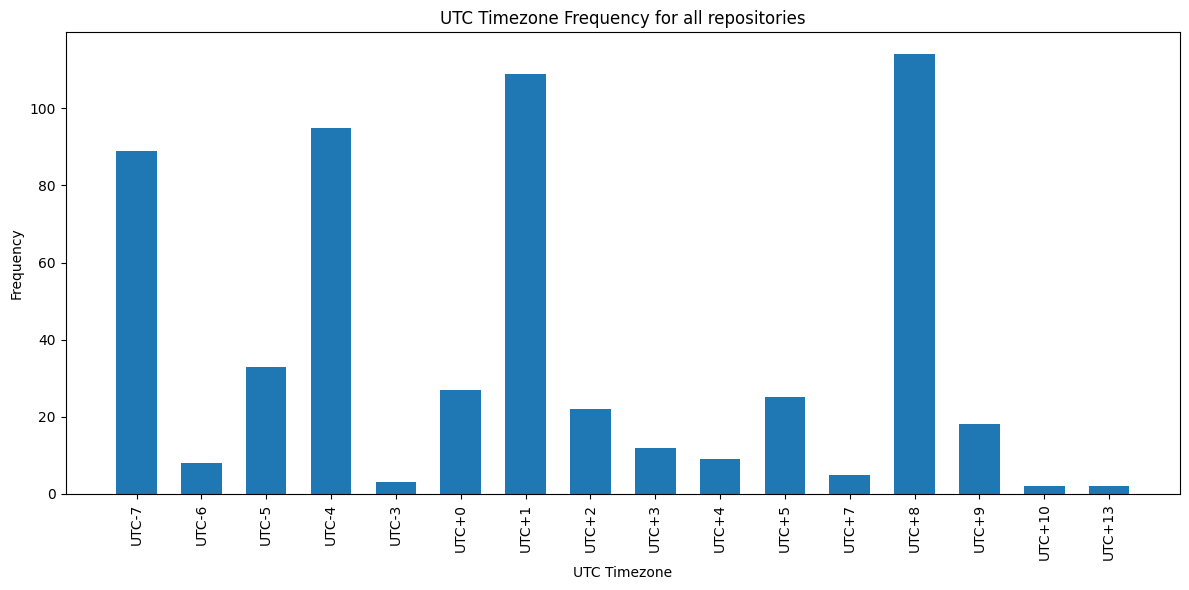

In [12]:
import json
import matplotlib.pyplot as plt
import numpy as np

with open("data_rq1/RQ1_utc_ordered_avg_prs.json", "r") as f:
    data = json.load(f)


def calculate_simpson_index(data):
    total = sum(data.values())
    simpson_index = sum((count / total) ** 2 for count in data.values())
    diversity_index = 1 - simpson_index
    return diversity_index

# Create a dictionary to store the frequencies
timezone_frequencies = {}

for item in data:
    #print(item['average_pr_time'])
    for timezone, count in item.items():
        if isinstance(count, int) and timezone != "repo_name" and timezone != "average_pr_time" and timezone != "nr_timezones" and timezone != "timezone_difference":
            if timezone not in timezone_frequencies:
                timezone_frequencies[timezone] = 0
            timezone_frequencies[timezone] += count

# Calculate Simpson Diversity Index for timezone frequencies
simpson_diversity_timezones = calculate_simpson_index(timezone_frequencies)
print(f"Simpson Diversity Index for timezone frequencies: {simpson_diversity_timezones}")

# Separate the timezones into two lists
utc_plus_timezones = []
utc_minus_timezones = []

for timezone, count in timezone_frequencies.items():
    if timezone.startswith("UTC+"):
        utc_plus_timezones.append((timezone, count))
    elif timezone.startswith("UTC-"):
        utc_minus_timezones.append((timezone, count))

# Order the lists
utc_plus_timezones.sort(key=lambda x: int(x[0][4:]), reverse=False)
utc_minus_timezones.sort(key=lambda x: int(x[0][4:]), reverse=True)

# Merge the lists
frequency_timezones_all_repos = utc_minus_timezones + utc_plus_timezones

# Calculate Simpson Diversity Index for average_pr_time
average_pr_times = [item['average_pr_time'] for item in data]
average_pr_time_frequencies = {time: average_pr_times.count(time) for time in set(average_pr_times)}
simpson_diversity_average_pr_time = calculate_simpson_index(average_pr_time_frequencies)
print(f"Simpson Diversity Index for average_pr_time: {simpson_diversity_average_pr_time}")

# Plot the histogram
plt.figure(figsize=(12, 6))
x_values = [tz[0] for tz in frequency_timezones_all_repos]
y_values = [tz[1] for tz in frequency_timezones_all_repos]
bar_width = 10 / len(frequency_timezones_all_repos)
plt.bar(x_values, y_values, width=bar_width)
plt.xticks(rotation=90)
plt.xlabel("UTC Timezone")
plt.ylabel("Frequency")
plt.title("UTC Timezone Frequency for all repositories")
plt.tight_layout()
plt.show()

## 5. Statistical analysis 🧐

1. Correlation analysis between avg time to merge and nr distinct timezones and avg time to merge and timezone difference.
   -  Correlation between **average-time-to-merge** and **nr_timezones**: -0.13109702861685862. 
This means a Weak Negative Relationship. Therefore, as the number of distinct timezones in a repository increases, the average-time-to-merge decreases. 🤔
   -  Correlation between **average-time-to-merge** and **timezone_difference**: -0.07380471146079941. 
This value indicates a very Weak Negative Relationship. As the value is close to 0, it can mean that there is almost no relationship between the 2 metrics, however, since it's a negative relationship, it might potentially suggest that as the difference in timezones is greater, the average-time-to-merge decreases. 🤔
1. 2-sample t-test 
   - In a two-sample t-test, the t-statistic measures the difference between the means of the two groups.
   - **t-statistic**: -0.5187452474745563
   The t-statistic is negative, which suggests that the mean of the first group (repositories with number of distinct timezones >= 5) is lower than the mean of the second group (repositories with number of distinct timezones < 5). However, the magnitude of the t-statistic is relatively small, indicating that the difference between the means is not very large. The t-test results suggest that the difference between the mean average-time-to-merge for repositories with number of distinct timezones greater than or equal to 5 and those with number of distinct timezones less than 5 is not statistically significant at the commonly used significance levels. 
   - **p-value**: 0.6065377166927663
   The p-value is relatively high, which is greater than the commonly used significance levels of 0.05 or 0.01. This means that the observed difference between the means is not statistically significant at these levels. We cannot reject the null hypothesis that the means of the two groups are equal. The high p-value indicates that the observed difference could be due to random chance or sampling variation, and there is not enough evidence to conclude that the number of distinct timezones has a significant impact on the average time to merge a pull request.
2. Spearman test
   - The Spearman test measures the monotonic relationship between two variables.
   - Spearman test for average-time-to-merge and nr distinct timezones is 0.1873624213239356
   This positive value suggests a weak positive monotonic relationship between the two variables. As the number of distinct timezones increases, the average time to merge a pull request tends to increase slightly, but the relationship is relatively weak. 🤔
   - Spearman test for average-time-to-merge and timezone difference is 0.15054517857239832 
   This positive value also indicates a weak positive monotonic relationship between the two variables. As the timezone difference increases, the average time to merge a pull request tends to increase slightly, but the relationship is very weak. 🤔
3. OLS linear regression model
   - R-squared: 0.019 (1.9%) and Adjusted R-squared: -0.026 (-2.6%). 
  This model might not be a good fit for our data.
   - F-statistic: 0.4263 and Prob (F-statistic): 0.656
  The results indicate that the model is not statistically significant. In other words, the independent variables nr_timezones and timezone_difference do not have a significant combined effect on average-time-to-merge.
   - Overall, the regression analysis suggests that the number of distinct timezones and the timezone difference do not have a statistically significant impact on the average time to merge. The model has a poor fit, and the diagnostic statistics indicate potential issues with the model assumptions 😓.

t-statistic: -0.5187452474745563
p-value: 0.6065377166927663
Spearman test for time-to-merge and nr distinct timezones is 0.1873624213239356
Spearman test for time-to-merge and timezone difference is 0.15054517857239832
                            OLS Regression Results                            
Dep. Variable:        average_pr_time   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                    0.4263
Date:                Wed, 27 Mar 2024   Prob (F-statistic):              0.656
Time:                        21:49:20   Log-Likelihood:                -342.23
No. Observations:                  46   AIC:                             690.5
Df Residuals:                      43   BIC:                             696.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                

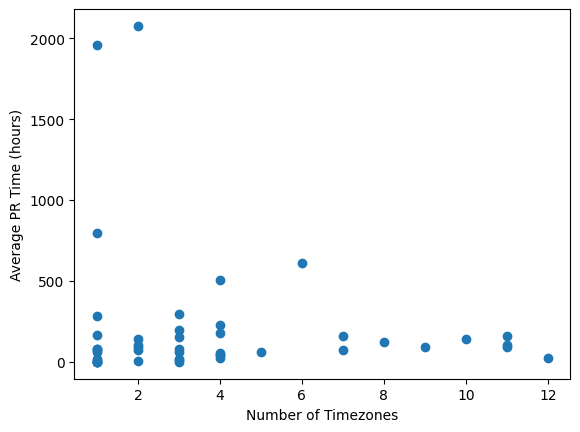

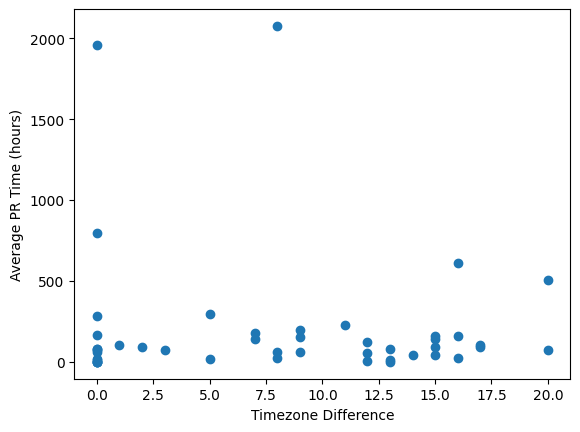

In [17]:
import json
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

with open('data_rq1/RQ1_utc_ordered_avg_prs.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Split the data based on nr_timezones
df_nr_timezones_gte_5 = df[df['nr_timezones'] >= 5]
df_nr_timezones_lt_5 = df[df['nr_timezones'] < 5]

# Perform a two-sample t-test
t_stat, p_val = stats.ttest_ind(df_nr_timezones_gte_5['average_pr_time'], df_nr_timezones_lt_5['average_pr_time'])

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_val}")

# Spearman test
spearman_test_nr_timezones = stats.spearmanr(df['average_pr_time'], df['nr_timezones'])
print(f"Spearman test for time-to-merge and nr distinct timezones is {spearman_test_nr_timezones.statistic}")

spearman_test_timezone_diff = stats.spearmanr(df['average_pr_time'], df['timezone_difference'])
print(f"Spearman test for time-to-merge and timezone difference is {spearman_test_timezone_diff.statistic}")

# Add a constant to the independent variables
X = sm.add_constant(df[['nr_timezones', 'timezone_difference']])
y = df['average_pr_time']

# Fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

# Correlation between average_pr_time and nr_timezones
corr_avg_pr_time_nr_timezones = df['average_pr_time'].corr(df['nr_timezones'])
print(f"Correlation between average_pr_time and nr_timezones: {corr_avg_pr_time_nr_timezones}")

# Correlation between average_pr_time and timezone_difference
corr_avg_pr_time_timezone_diff = df['average_pr_time'].corr(df['timezone_difference'])
print(f"Correlation between average_pr_time and timezone_difference: {corr_avg_pr_time_timezone_diff}")

# Scatterplot of average_pr_time vs nr_timezones
plt.scatter(df['nr_timezones'], df['average_pr_time'])
plt.xlabel('Number of Timezones')
plt.ylabel('Average PR Time (hours)')
plt.show()

# Scatterplot of average_pr_time vs timezone_difference
plt.scatter(df['timezone_difference'], df['average_pr_time'])
plt.xlabel('Timezone Difference')
plt.ylabel('Average PR Time (hours)')
plt.show()